# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# PARTE PARTE: TEXT SUMMARIZATION

## I. Declaración de librerías

In [1]:
# Librerías de apoyo
# ==============================================================================
from tqdm import tqdm

# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
#import numpy as np
#import mglearn
from sklearn.model_selection import train_test_split

# Tratamiento de texto
# ==============================================================================
#from nltk import FreqDist
#from nltk import word_tokenize
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.model_selection import GridSearchCV
#from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras import backend as K

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')



# Configuración matplotlib
# ==============================================================================
# Para obtener el estilo de plot de seabonr
plt.style.use('seaborn-whitegrid')
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

# otras configuraciones
# ==============================================================================
tqdm.pandas()
#pd.set_option("display.max_colwidth", 200)

import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"


## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 771 ms, sys: 43.3 ms, total: 814 ms
Wall time: 812 ms


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary
1552,CONSEJO EJECUTIVO DEL PODER JUDICIAL,RESOLUCION ADMINISTRATIVA N° 000204-2021-CE-PJ,15/07/2021,Rectifican de oficio error material incurrido ...,"Lima, 8 de julio del 2021 VISTO: El Oficio N° ...",lima julio visto oficio cursado gerencia gener...,lima julio visto oficio cursado gerencia gener...,rectifican oficio error material incurrido dir...
3389,MUNICIPALIDAD DE MIRAFLORES,DECRETO DE ALCALDIA N° 006-2021/MM,06/06/2021,Disponen el embanderamiento general y obligato...,"Miraflores, 27 de mayo de 2021 EL ALCALDE DE M...",miraflor mayo alcalde miraflor constitución po...,miraflores mayo alcalde miraflores constitució...,disponen embanderamiento general obligatorio v...
2815,CULTURA,RESOLUCION VICE MINISTERIAL N° 000139-2021-VM...,18/06/2021,Declaran Patrimonio Cultural de la Nación a lo...,"San Borja, 15 de junio del 2021 VISTOS; el Inf...",borjo junio visto informe dirección general mu...,borja junio vistos informe dirección general m...,declaran patrimonio cultural nación ciento vei...
559,ORGANISMO SUPERVISOR DE INVERSION PRIVADA EN T...,RESOLUCION N° 137-2021-CD/OSIPTEL,01/08/2021,Aprueban la Norma Técnica relativa a la implem...,"Lima, 30 de julio de 2021 VISTO: El Proyecto d...",lima julio visto proyecto resolución presentad...,lima julio visto proyecto resolución presentad...,aprueban norma técnica relativa implementación...
3694,SEGURO INTEGRAL DE SALUD,RESOLUCION JEFATURAL N° 066-2021/SIS,31/05/2021,Disponen acciones que resulten necesarias para...,"Lima, 30 de mayo de 2021 VISTOS: El Informe Co...",lima mayo visto informe conjunto gadjsga sgpp ...,lima mayo vistos informe conjunto gadjsga sgpp...,disponen acciones resulten necesarias extensió...


___
Utilizar las columnas: 
* **content_for_summary**
* **abstract_for_summary**

Estas columnas a diferencia de **content_for_topic** son textos pre-procesados sin stemmer o lemmatizer. Es necesario mantener la palabras originales para ayudar a la red a mejorar su exactitus en la generación del "summary" 
___

In [3]:
# Limpieza del dataset
print("Dimensiones:", dataset_base.shape)
print("Filas que no contiene valores nulos:", len(dataset_base[dataset_base.content_for_topic.notna()]))
print("Filas con valores nulos:", len(dataset_base[dataset_base.isnull().any(axis=1)]))

Dimensiones: (4099, 8)
Filas que no contiene valores nulos: 4063
Filas con valores nulos: 36


In [4]:
# Eliminar registros que contienen valores nulos
dataset_base.dropna(inplace=True)
print("Dimensiones:", dataset_base.shape)

Dimensiones: (4063, 8)


In [5]:
%%time
# Eliminar registros que viene de una corrección, identificado como "errata"
print("Filas con errata:", dataset_base[dataset_base.abstract_for_summary == "errata"].shape[0])

# Eliminar las filas
dataset_base.drop(dataset_base[dataset_base.abstract_for_summary == "errata"].index, inplace = True)
print("Nuevas dimensiones:", dataset_base.shape)

Filas con errata: 52
Nuevas dimensiones: (4011, 8)
CPU times: user 4.08 ms, sys: 23 µs, total: 4.1 ms
Wall time: 3.33 ms


In [6]:
%%time
# Función para marcar el texto que servira al Decoder del modelo Seq2Seq
dataset_base["abstract_for_decoder"] = dataset_base.abstract_for_summary.apply(lambda t: "_START_ " + t + " _END_")
dataset_base.sample(5)

CPU times: user 5.49 ms, sys: 0 ns, total: 5.49 ms
Wall time: 4.2 ms


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary,abstract_for_decoder
628,MUNICIPALIDAD DE VILLA MARIA DEL TRIUNFO,DECRETO DE ALCALDIA N° 008-2021-MVMT,30/07/2021,Prorrogan vigencia de la Ordenanza N° 315-MVMT...,"Villa María del Triunfo, 20 de julio de 2021 E...",villo maría triunfo julio alcalde villo maría ...,villa maría triunfo julio alcalde villa maría ...,prorrogan vigencia ordenanza mvmt establece be...,_START_ prorrogan vigencia ordenanza mvmt esta...
266,EDUCACION,RESOLUCION VICE MINISTERIAL N° 248-2021-MINEDU,11/08/2021,Aprueban el documento normativo denominado Ori...,"Lima, 10 de agosto de 2021 VISTOS, el Expedien...",lima agosto visto expediente informe minedu vm...,lima agosto vistos expediente informes minedu ...,aprueban documento normativo denominado orient...,_START_ aprueban documento normativo denominad...
2494,MUNICIPALIDAD PROVINCIAL DEL CALLAO,DECRETO DE ALCALDIA N° 03-2021-DA/MPC,25/06/2021,Prorrogan plazo para la inscripción de los rep...,"Callao, 24 de junio del 2021 EL ALCALDE DE LA ...",callao junio alcalde municipalidad provincial ...,callao junio alcalde municipalidad provincial ...,prorrogan plazo inscripción representantes soc...,_START_ prorrogan plazo inscripción representa...
3505,MUNICIPALIDAD DISTRITAL DE PAPAYAL,ORDENANZA N° 006-2020-MDP,04/06/2021,Ordenanza que aprueba el Cuadro para Asignació...,"Papayal, 29 de diciembre del 2020 EL ALCALDE D...",papayal diciembre alcalde municipalidad distri...,papayal diciembre alcalde municipalidad distri...,ordenanza aprueba cuadro asignación personal p...,_START_ ordenanza aprueba cuadro asignación pe...
2407,JUSTICIA Y DERECHOS HUMANOS,RESOLUCION VICE MINISTERIAL N° 003-2021-JUS-VMJ.,26/06/2021,Aprueban el Lineamiento para la atención de so...,"Lima, 24 de junio de 2021 VISTOS, el Memorando...",lima junio visto memorando dgdncr informe dgdn...,lima junio vistos memorando dgdncr informes dg...,aprueban lineamiento atención solicitudes dict...,_START_ aprueban lineamiento atención solicitu...


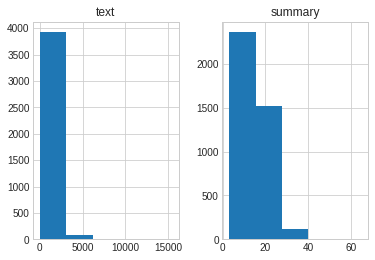

In [7]:
text_count = []
summary_count = []


for sent in dataset_base.content_for_summary:
    text_count.append(len(sent.split()))
for sent in dataset_base.abstract_for_decoder:
    summary_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

graph_df.hist(bins = 5)
plt.show()

In [8]:
%%time
# El modelo realizará resumen entre 1-50 palabras para contenidos/textos
# entre 1 y 5000 palabras.
max_content_len=5000
max_summary_len=50

print("="*50)
# Verificar el porcentaje de palabras en el content entre 1 y max_content_len

print("% content de palabras entre 1 y " + str(max_content_len) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 0 and
                       len(v.content_for_summary.split()) <= max_content_len, axis=1)
].shape[0]/len(dataset_base.content_for_summary)
)

# Verificar el porcentaje de palabras en el abstract entre 1 y max_summary_len

print("% abstract de palabras entre 1 y " + str(max_summary_len) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.abstract_for_decoder.split()) > 0 and
                       len(v.abstract_for_decoder.split()) <= max_summary_len, axis=1)
].shape[0]/len(dataset_base.abstract_for_decoder)
)
print("="*50)

% content de palabras entre 1 y 5000: 0.9930191972076788
% abstract de palabras entre 1 y 50: 0.9992520568436799
CPU times: user 444 ms, sys: 4.3 ms, total: 448 ms
Wall time: 445 ms


In [9]:
%%time
dataset_pre = \
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 0 and
                       len(v.content_for_summary.split()) <= max_content_len and
                       len(v.abstract_for_decoder.split()) > 0 and
                       len(v.abstract_for_decoder.split()) <= max_summary_len, axis=1)
][["content_for_summary","abstract_for_decoder"]]

dataset_pre.rename(columns={"content_for_summary":"content","abstract_for_decoder":"summary"}, inplace=True)
dataset_pre.sample(5)

CPU times: user 447 ms, sys: 0 ns, total: 447 ms
Wall time: 446 ms


,content,summary
1589,lima julio vistos expediente informes minedu v...,_START_ aprueban documento normativo denominad...
3067,lima junio vistos informe mimp optp oficina pr...,_START_ designan director general oficina gene...
3618,expediente ignacio cajamarca vacancia convocat...,_START_ convocan ciudadano asuma cargo regidor...
1715,lima julio vistos informe minam vmga dgca dcae...,_START_ disponen publicación proyecto guía eva...
852,lima julio vistos recurso apelación interpuest...,_START_ declaran infundado recurso apelación i...


In [10]:
%%time
#Add sostok and eostok at 
dataset_pre.summary = dataset_pre.summary.apply(lambda v : "sostok " + v + " eostok")
dataset_pre.sample(2)

CPU times: user 1.91 ms, sys: 526 µs, total: 2.43 ms
Wall time: 2.18 ms


,content,summary
3532,constitución política perú consagra derecho vo...,sostok _START_ decreto supremo otorga facilida...
3726,lima mayo vistos expedientes contienen informe...,sostok _START_ oficializan examen nacional nut...


In [11]:
%%time
x_tr_i, x_val_i, y_tr_i, y_val_i = train_test_split(dataset_pre.content, dataset_pre.summary, test_size=0.1, random_state=0, shuffle=True)
x_tr_i.shape, x_val_i.shape

CPU times: user 5.78 ms, sys: 352 µs, total: 6.13 ms
Wall time: 4.94 ms


((3582,), (398,))

In [12]:
#from keras import backend as K
#from tensorflow.keras import backend as K



RARE WORD ANALYSIS FOR Y i.e 'summary'

    tot_cnt gives the size of vocabulary (which means every unique words in the text)

    cnt gives me the no. of rare words whose count falls below threshold

    tot_cnt - cnt gives me the top most common words



In [13]:
%%time
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(x_tr_i)

thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
tot_cnt,cnt, tot_cnt-cnt, len(x_tokenizer.word_counts)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(x_tr_i)

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr_i) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val_i)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_content_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_content_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))
len(x_tokenizer.word_counts)

% of rare words in vocabulary: 41.938566915337034
Total Coverage of rare words: 0.8440977418155561
Size of vocabulary in X = 21871
CPU times: user 7.51 s, sys: 14.5 ms, total: 7.52 s
Wall time: 7.52 s


37667

In [14]:
%%time
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_tr_i)



thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(y_tr_i)

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr_i) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val_i) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 59.243986254295535
Total Coverage of rare words: 7.164159538557337
Size of vocabulary in Y = 2373
CPU times: user 269 ms, sys: 0 ns, total: 269 ms
Wall time: 268 ms


In [15]:
%%time
print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()


latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_content_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 21871
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 200)    4374200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5000, 300),  601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [16]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [18]:
y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:].shape, y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:].shape, len([x_tr,y_tr[:,:-1]][1]), len([x_val,y_val[:,:-1]][1])

((398, 49, 1), (3582, 49, 1), 3582, 398)

In [19]:
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
    epochs=50, callbacks=[es], batch_size=128, 
    validation_data= ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/50


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node gradient_tape/model/embedding/embedding_lookup/Reshape/_36}}]] [Op:__inference_train_function_11176]

Function call stack:
train_function
